In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [172]:
df_dev = pd.read_csv('../dataset/development.csv')
df_eval = pd.read_csv('../dataset/evaluation.csv')

df = pd.concat([df_dev, df_eval], sort=False)
df.head()

,id,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel,weekday
0,0,http://mashable.com/2014/09/08/safest-cabbies-...,121.0,12.0,1015.0,0.422018,1.0,0.545031,10.0,6.0,...,-0.160714,-0.50,-0.071429,0.0,0.00,0.5,0.00,2900.0,bus,tuesday
1,1,http://mashable.com/2013/07/25/3d-printed-rifle/,532.0,9.0,503.0,0.569697,1.0,0.737542,9.0,0.0,...,-0.157500,-0.25,-0.100000,0.0,0.00,0.5,0.00,1300.0,tech,thursday
2,2,http://mashable.com/2013/10/30/digital-dinosau...,435.0,9.0,232.0,0.646018,1.0,0.748428,12.0,3.0,...,-0.427500,-1.00,-0.187500,0.0,0.00,0.5,0.00,17700.0,lifestyle,wednesday
3,3,http://mashable.com/2014/08/27/homer-simpson-i...,134.0,12.0,171.0,0.722892,1.0,0.867925,9.0,5.0,...,-0.216667,-0.25,-0.166667,0.4,-0.25,0.1,0.25,1500.0,bus,wednesday
4,4,http://mashable.com/2013/01/10/creepy-robotic-...,728.0,11.0,286.0,0.652632,1.0,0.800000,5.0,2.0,...,-0.251786,-0.50,-0.100000,0.2,-0.10,0.3,0.10,1400.0,tech,thursday


## Categorical data

### OneHot Encoding
- OneHot Encoding generates redundant data: if the ml model requires too much time to train itself or the model overfits, then the Effect Coding or Dummy Encoding could help to reduce the number of features.

In [173]:
enc = OneHotEncoder()
encoded_df = pd.concat([df_dev['weekday'], df_dev['data_channel']], axis=1)
enc.fit(encoded_df)
encoded_df = enc.transform(encoded_df)
additional_columns = enc.get_feature_names_out()
print(encoded_df.toarray().shape)
working_df_dev = df_dev.copy()
working_df_dev[additional_columns] = encoded_df.toarray()
working_df_dev.drop(['weekday', 'data_channel', 'url', 'id'], axis = 1, inplace=True)

(31715, 13)


## Numerical data

### Feature selection based on correlation
- Features to delete (look at multivariate analysis):
    - n_unique_tokens
    - n_non_stop_words
    - kw_max_min
    - kw_min_max
    - kw_max_avg
    - abs_title_sentiment_polarity
    - abs_title_subjectivity
    - rate_positive_words 
    - timedelta
    - max_negative_polarity
    - min_negative_polarity
    - kw_min_min
    - kw_max_max
    - num_self_hrefs
    - n_tokens_content (to be verified)
    - data_channel_business
    - LDA_00

In [174]:
#working_df_dev.drop(columns=['n_non_stop_words', 'kw_min_min', 'kw_max_max'], inplace=True)
'''working_df_dev.drop(columns=['n_unique_tokens','n_non_stop_words','kw_max_min','kw_min_max','kw_max_avg','abs_title_sentiment_polarity',
                     'abs_title_subjectivity','rate_positive_words','timedelta','max_negative_polarity','min_negative_polarity',
                     'kw_min_min','kw_max_max','num_self_hrefs','data_channel_bus','LDA_00'], inplace=True)'''

"working_df_dev.drop(columns=['n_unique_tokens','n_non_stop_words','kw_max_min','kw_min_max','kw_max_avg','abs_title_sentiment_polarity',\n                     'abs_title_subjectivity','rate_positive_words','timedelta','max_negative_polarity','min_negative_polarity',\n                     'kw_min_min','kw_max_max','num_self_hrefs','data_channel_bus','LDA_00'], inplace=True)"

### Feature selection based on univariate analysis
- Features to delete:
    - n_tokens_content: It can be observed that there are a lot of values equal to 0 words: this can be due to an error during the data collection step. As solution, we decide to drop the records corresponding to the value zero of this feature (3% of the whole dataset)
    - kw_avg_min: its distribution does not improve even after the preprocessing step
    - kw_min_avg: its distribution does not improve even after the preprocessing ste
    - self_reference_min_shares: --> TO BE VERIFIED (its distribution does not improve even after the preprocessing step)
    - self_reference_max_shares: --> TO BE VERIFIED (its distribution does not improve even after the preprocessing step)
    - self_reference_avg_sharess: --> TO BE VERIFIED (its distribution does not improve even after the preprocessing step)
    - LDA_01: --> TO BE VERIFIED, very low correlation with the dependent variable; it does not provide any important information
    - LDA_02: --> TO BE VERIFIED, very low correlation with the dependent variable; it does not provide any important information
    - LDA_03: --> TO BE VERIFIED, very low correlation with the dependent variable; it does not provide any important information
    - LDA_04: --> TO BE VERIFIED, very low correlation with the dependent variable; it does not provide any important information
- Features to transform:
    - num_imgs: Filled NaN values with the mean and rescaled in logarithmic scale to better distribute data and remove outliers.
    - num_videos: Filled NaN values with the mean and rescaled in logarithmic scale to better distribute data and remove outliers.
    - n_tokens_content: Rescaled in logarithmic scale to better distribute data and remove outliers
    - avg_negative_polarity: Use absolute value to bring the range of this feature between [0, +1] as the corresponding "avg_positive_polarity" features
    - num_keywords: Filled NaN values with the mean group by the data channel attribute
    - num_hrefs: Rescaled in logarithmic scale to better distribute data
    - shares: Rescaled in logarithmic scale to better distribute data
    - kw_avg_avg: remove outliers using the quartiles; in this way the dataset is reduced by another 9%
    - weekdays: transform weekdays into a boolean status "isWeekend" since we've observed that the principal discrimination is based on weather the article is published on the weekend or not --> TO BE VERIFIED
- Features to scale:
    - n_tokens_content: standard scaler
    - n_tokens_title: standard scaler
    - num_keywords: min-max scaler (since it's just a discrete value within a delimited range)
    - kw_avg_min: standard scaler
    - kw_avg_max: standard scaler
    - kw_min_avg: standard scaler
    - kw_avg_avg: standard scaler
    - self_reference_min_shares: standard scaler
    - self_reference_max_shares: standard scaler
    - self_reference_avg_sharess: standard scaler

In [175]:
#working_df_dev = working_df_dev.query("n_tokens_content > 0")

In [176]:
working_df_dev['n_tokens_content'] = np.log(1 + working_df_dev['n_tokens_content'])
#working_df_dev.drop(columns=['n_tokens_content'], inplace=True)

In [177]:
working_df_dev['num_imgs'].fillna(0, inplace=True)
#working_df_dev['num_imgs'].fillna(working_df_dev['num_imgs'].mean(), inplace=True)
#working_df_dev['num_imgs'] = np.log(1+working_df_dev['num_imgs'])

In [178]:
working_df_dev['num_self_hrefs'].fillna(0, inplace=True)
#working_df_dev['num_self_hrefs'].fillna(working_df_dev['num_self_hrefs'].mean(), inplace=True)
#working_df_dev['num_self_hrefs'] = np.log(1+working_df_dev['num_self_hrefs'])

In [179]:
working_df_dev['num_videos'].fillna(0, inplace=True)
#working_df_dev['num_videos'].fillna(working_df_dev['num_videos'].mean(), inplace=True)
#working_df_dev['num_videos'] = np.log(1+working_df_dev['num_videos'])

In [180]:
std_scaler = StandardScaler().fit(working_df_dev[['n_tokens_title', 'n_tokens_content']])
scaled_features = std_scaler.transform(working_df_dev[['n_tokens_title', 'n_tokens_content']])
working_df_dev[['n_tokens_title', 'n_tokens_content']] = scaled_features

In [181]:
#working_df_dev['avg_negative_polarity'] = working_df_dev['avg_negative_polarity'].abs()

In [182]:
# Since this features has a range between [0, 10], we can apply a min max scaling
working_df_dev['num_keywords'].fillna(0, inplace=True)
#working_df_dev['num_keywords'] = df_dev.groupby(['data_channel'], sort=False)['num_keywords'].apply(lambda x: x.fillna(x.mean())).reset_index()['num_keywords']

'''std_scaler = MinMaxScaler().fit(working_df_dev[['num_keywords']])
scaled_features = std_scaler.transform(working_df_dev[['num_keywords']])
working_df_dev[['num_keywords']] = scaled_features'''

"std_scaler = MinMaxScaler().fit(working_df_dev[['num_keywords']])\nscaled_features = std_scaler.transform(working_df_dev[['num_keywords']])\nworking_df_dev[['num_keywords']] = scaled_features"

In [183]:
working_df_dev['shares'] = np.log(working_df_dev['shares'])

In [184]:
# Remove outliers from kw_avg_avg (we lost another 9% of the dataset)
q1 = working_df_dev['kw_avg_avg'].describe()['25%']
q3 = working_df_dev['kw_avg_avg'].describe()['75%']
iqr = q3 - q1
min_kw_avg_avg = q1 - 1.5*iqr
max_kw_avg_avg = q3 + 1.5*iqr
working_df_dev = working_df_dev[(df_dev.kw_avg_avg < max_kw_avg_avg) & (df_dev.kw_avg_avg > min_kw_avg_avg)]

#working_df_dev.drop(columns=['kw_avg_min', 'kw_min_avg'], inplace=True)

std_scaler = StandardScaler().fit(working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg', 'kw_max_avg', 'kw_max_min', 'kw_min_max']])
scaled_features = std_scaler.transform(working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg','kw_max_avg', 'kw_max_min', 'kw_min_max']])
working_df_dev[['kw_avg_max', 'kw_avg_avg', 'kw_avg_min', 'kw_min_avg','kw_max_avg', 'kw_max_min', 'kw_min_max']] = scaled_features

In [185]:
'''working_df_dev['kw_avg_max'] = np.log(1 + working_df_dev['kw_avg_max'])
working_df_dev['kw_avg_avg'] = np.log(1 + working_df_dev['kw_avg_avg'])
working_df_dev['kw_avg_min'] = np.log(2 + working_df_dev['kw_avg_min'])
working_df_dev['kw_min_avg'] = np.log(2 + working_df_dev['kw_min_avg'])
working_df_dev['kw_max_avg'] = np.log(1 + working_df_dev['kw_max_avg'])
working_df_dev['kw_max_min'] = np.log(1 + working_df_dev['kw_max_min'])
working_df_dev['kw_min_max'] = np.log(1 + working_df_dev['kw_min_max'])
working_df_dev['kw_min_min'] = np.log(2 + working_df_dev['kw_min_min'])
working_df_dev['kw_max_max'] = np.log(1 + working_df_dev['kw_max_max'])'''

/Users/lorenzo/University/Polito/Data science lab/predict-shares-online-news/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [186]:
#working_df_dev.drop(columns=['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess'], inplace=True)

std_scaler = StandardScaler().fit(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
scaled_features = std_scaler.transform(working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']])
working_df_dev[['self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess']] = scaled_features

In [187]:
working_df_dev['num_hrefs'] = np.log(1 + working_df_dev['num_hrefs'])

In [188]:
# Drop LDA features because they are not well distributed even after the data preprocessing step...
# Maybe it's possible to check if the AdjR2_score experienced an increase when we add them

#working_df_dev.drop(columns=['LDA_01', 'LDA_02', 'LDA_03', 'LDA_04'], inplace=True)

In [189]:
# Transform weekdays into a boolean status "isWeekend" since we've observed that the principal discrimination is based on
# weather the article is published on the weekend or not
is_weekend = []
for _, row in working_df_dev.iterrows():
    if row['weekday_sunday'] == 1 or row['weekday_saturday'] == 1:
        is_weekend.append(1)
    else:
        is_weekend.append(0)
working_df_dev['is_weekend'] = is_weekend
working_df_dev.drop(columns=[x for x in additional_columns if x.startswith('weekday')], inplace=True)

In [190]:
# Drop min_positive_polarity,max_positive_polarity features because they are not well distributed even after the data preprocessing step...
# In addition, there are the "avg" version of these features that better explain the polarity of the article's content

#working_df_dev.drop(columns=['min_positive_polarity', 'max_positive_polarity'], inplace=True)

In [191]:
std_scaler = StandardScaler().fit(working_df_dev[['timedelta']])
scaled_features = std_scaler.transform(working_df_dev[['timedelta']])
working_df_dev[['timedelta']] = scaled_features

In [192]:
working_df_dev

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel_bus,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,data_channel_world,is_weekend
0,-1.097287,0.760665,0.826046,0.422018,1.0,0.545031,2.397895,6.0,33.0,1.0,...,0.500000,0.000000,7.972466,1.0,0.0,0.0,0.0,0.0,0.0,0
1,0.816856,-0.657366,0.267180,0.569697,1.0,0.737542,2.302585,0.0,0.0,1.0,...,0.500000,0.000000,7.170120,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.365100,-0.657366,-0.347875,0.646018,1.0,0.748428,2.564949,3.0,4.0,1.0,...,0.500000,0.000000,9.781320,0.0,0.0,1.0,0.0,0.0,0.0,0
3,-1.036742,0.760665,-0.589855,0.722892,1.0,0.867925,2.302585,5.0,0.0,0.0,...,0.100000,0.250000,7.313220,1.0,0.0,0.0,0.0,0.0,0.0,0
4,1.729683,0.287988,-0.181708,0.652632,1.0,0.800000,1.791759,2.0,0.0,0.0,...,0.300000,0.100000,7.244228,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31709,-1.269606,0.287988,0.290560,0.500000,1.0,0.703008,2.302585,0.0,1.0,1.0,...,0.211111,0.155556,6.527958,0.0,0.0,1.0,0.0,0.0,0.0,0
31710,-1.488498,0.287988,0.160732,0.564103,1.0,0.718978,2.397895,2.0,0.0,0.0,...,0.500000,0.000000,6.907755,0.0,0.0,0.0,0.0,0.0,1.0,0
31712,-1.097287,-0.657366,0.789111,0.489583,1.0,0.710623,1.945910,5.0,2.0,1.0,...,0.500000,0.000000,7.783224,0.0,0.0,0.0,0.0,1.0,0.0,0
31713,0.681795,0.287988,1.356736,0.412308,1.0,0.621080,3.091042,3.0,1.0,3.0,...,0.200000,0.400000,8.699515,0.0,0.0,1.0,0.0,0.0,0.0,0


In [193]:
working_df_dev.describe()
#working_df_dev.isna().any()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,abs_title_subjectivity,abs_title_sentiment_polarity,shares,data_channel_bus,data_channel_entertainment,data_channel_lifestyle,data_channel_socmed,data_channel_tech,data_channel_world,is_weekend
count,3.041000e+04,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,...,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000,30410.000000
mean,-1.252387e-16,0.000294,0.021333,0.531685,0.973331,0.675589,2.150163,3.287767,3.492864,0.990727,...,0.342228,0.153066,7.453556,0.161493,0.181717,0.186057,0.059849,0.192075,0.218810,0.131240
std,1.000016e+00,1.001838,0.965321,0.133976,0.161116,0.149502,0.795096,3.815807,7.592860,3.729647,...,0.188982,0.223626,0.911482,0.367991,0.385617,0.389159,0.237210,0.393938,0.413446,0.337668
min,-1.623559e+00,-3.966106,-4.693343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.970235e-01,-0.657366,-0.288554,0.471180,1.000000,0.627153,1.609438,1.000000,0.000000,0.000000,...,0.166667,0.000000,6.846146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-6.104147e-02,-0.184689,0.114208,0.538894,1.000000,0.691500,2.079442,3.000000,1.000000,0.000000,...,0.500000,0.000000,7.244228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.820580e-01,0.760665,0.551515,0.607774,1.000000,0.755556,2.639057,4.000000,2.000000,1.000000,...,0.500000,0.250000,7.901007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.738998e+00,5.960113,2.517066,1.000000,1.000000,1.000000,5.720312,116.000000,128.000000,91.000000,...,0.500000,1.000000,13.645078,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Other final adjustments based on the final result of this step

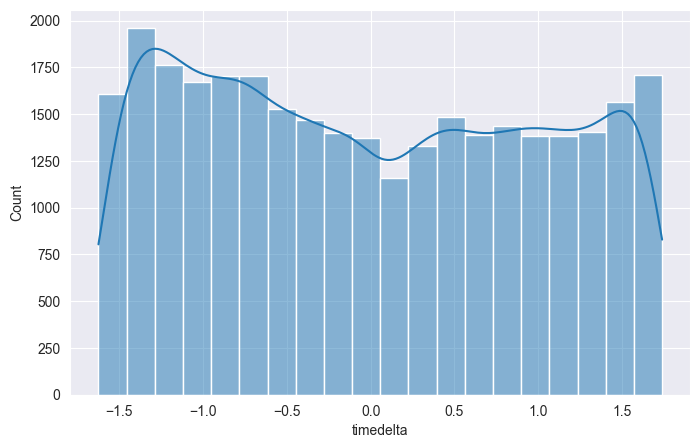

In [98]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sns.histplot(working_df_dev['timedelta'], bins=20, kde=True, ax=ax)
ax.grid()
plt.grid()
plt.show()

20468 31715


array([[<Axes: title={'center': 'num_imgs'}>]], dtype=object)

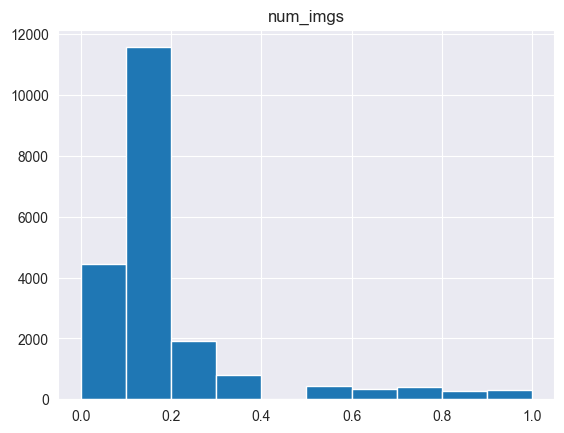

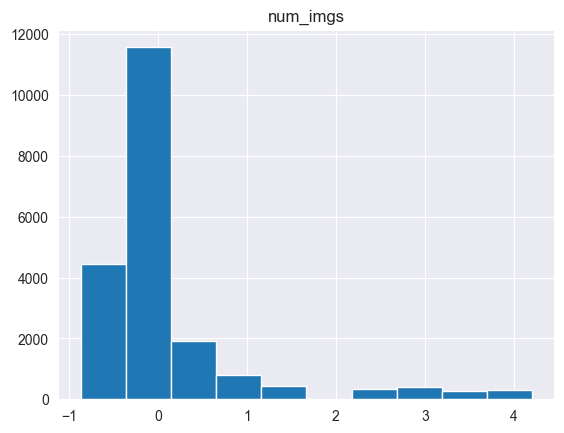

In [107]:
# remove outlier from num_imgs and see if the distribution improve
# se tagliamo fuori gli outliers usando i percentili si distribuisce meglio ma stiamo tagliando fuori il 20% del dataset
from sklearn.preprocessing import MinMaxScaler

q1 = df_dev['num_imgs'].describe()['25%']
q3 = df_dev['num_imgs'].describe()['75%']
iqr = q3 - q1
min_num_imgs = q1 - 1.5*iqr
max_num_imgs = q3 + 1.5*iqr
new_df_imgs = df_dev[(df_dev.num_imgs < max_num_imgs) & (df_dev.num_imgs > min_num_imgs)]
print(len(new_df_imgs), len(df_dev))

pd.DataFrame(data=MinMaxScaler(feature_range=(0, 1)).fit_transform(new_df_imgs[['num_imgs']]), columns=['num_imgs']).hist()
pd.DataFrame(data=StandardScaler().fit_transform(new_df_imgs[['num_imgs']]), columns=['num_imgs']).hist()
#pd.DataFrame(data=MinMaxScaler(feature_range=(0, 1)).fit_transform(df_dev[['num_imgs']]), columns=['num_imgs']).hist()
#pd.DataFrame(data=StandardScaler().fit_transform(df_dev[['num_imgs']]), columns=['num_imgs']).hist()

29994 31715
0.9457354564086394


<Axes: >

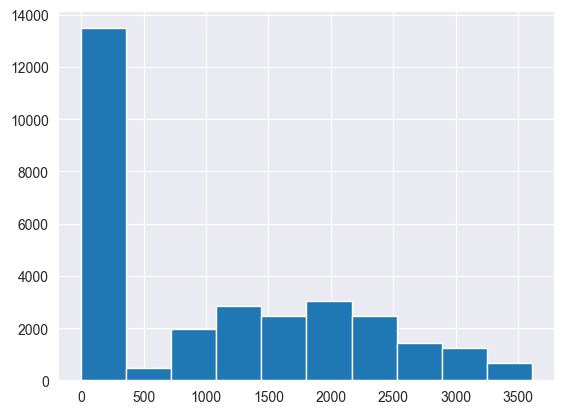

In [129]:
q1 = df_dev['kw_min_avg'].describe()['25%']
q3 = df_dev['kw_min_avg'].describe()['75%']
iqr = q3 - q1
min_kw_avg_avg = q1 - 1.5*iqr
max_kw_avg_avg = q3 + 1.5*iqr
new_df_kw_avg_avg = df_dev[(df_dev.kw_avg_avg < max_kw_avg_avg) & (df_dev.kw_avg_avg > min_kw_avg_avg)]
print(len(new_df_kw_avg_avg), len(df_dev))
print(len(new_df_kw_avg_avg) / len(df_dev))
new_df_kw_avg_avg['kw_min_avg'].hist()
#df_dev['kw_avg_avg'].hist()

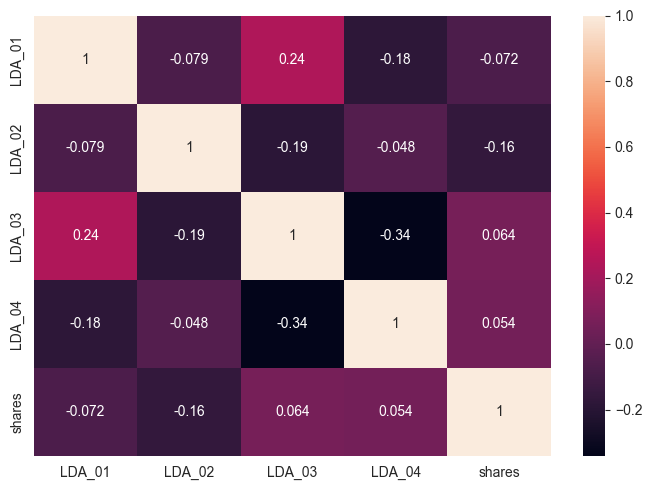

In [145]:
import seaborn as sns

lda = ['LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'shares']

_, ax = plt.subplots(1,1, figsize=(7, 5))
sns.heatmap(working_df_dev[lda].corr(method='spearman').loc[lda], ax=ax, annot=True)
plt.tight_layout()
plt.show()

<Axes: >

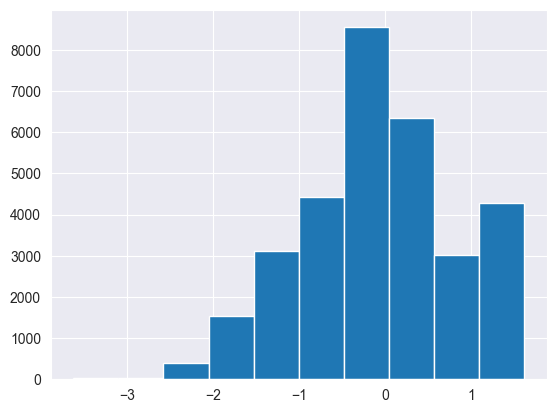

In [70]:
# Num Keywords improve its distribution when we fill the NaN values with the mean based on the data channel
new_df_keywords = df_dev.copy()
new_df_keywords['num_keywords'] = df_dev.groupby(['data_channel'], sort=False)['num_keywords'].apply(lambda x: x.fillna(x.mean())).reset_index()['num_keywords']

std_scaler = StandardScaler().fit(new_df_keywords[['num_keywords']])
scaled_features = std_scaler.transform(new_df_keywords[['num_keywords']])
new_df_keywords[['num_keywords']] = scaled_features
new_df_keywords['num_keywords'].hist()

## Features importance

### Features selected based on the importance
- Use RandomForestRegression to discover the features importance in order to predict the target variable
- The OneHot-Encoding features have a lower importance... It is possibile to try to delete them
- Without the OneHot-Encoding features the RMSE is higher and this means a worse result

In [169]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [194]:
reg = RandomForestRegressor(100, max_depth=50, min_samples_split=10, random_state=42)
reg.fit(X_train , y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
r2 = r2_score(y_valid, reg.predict(X_valid))
adj_r2 = 1-(1-r2)*(len(X_valid) - 1)/(len(X_valid) - X_valid.shape[1] - 1)
print(adj_r2)

''' Best result: (with shares as logarithm and the entire dataset with the feats.eng. steps)
0.8201237009452238
0.14645645198190094
Last result:
0.8415462480015808
0.1276782586131342
'''

0.8415102763761941
0.12775283124733772


' Best result: (with shares as logarithm and the entire dataset with the feats.eng. steps)\n0.8201237009452238\n0.14645645198190094\nLast result:\n0.8415462480015808\n0.1276782586131342\n'

In [95]:
feature_names = working_df_dev.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('kw_avg_avg', 0.0892176761007763),
 ('timedelta', 0.042217323970392996),
 ('kw_max_avg', 0.040984113497510535),
 ('self_reference_avg_sharess', 0.037869031429580285),
 ('kw_avg_max', 0.03185102003623674),
 ('LDA_04', 0.03053367385252624),
 ('global_subjectivity', 0.029405860907760345),
 ('n_non_stop_unique_tokens', 0.028850394277152757),
 ('self_reference_min_shares', 0.028742854428443335),
 ('LDA_01', 0.02865815312908556),
 ('average_token_length', 0.028483980690631655),
 ('LDA_03', 0.027225948634015618),
 ('LDA_00', 0.026906529779035297),
 ('avg_positive_polarity', 0.0268905772455742),
 ('global_sentiment_polarity', 0.026710353398602803),
 ('n_tokens_content', 0.0265869311934174),
 ('LDA_02', 0.02635572906232426),
 ('n_unique_tokens', 0.02628383521631607),
 ('kw_avg_min', 0.02566152347460161),
 ('num_hrefs', 0.025503124801951906),
 ('global_rate_positive_words', 0.024704110531352703),
 ('avg_negative_polarity', 0.023224604960793715),
 ('kw_max_min', 0.02311066377505615),
 ('global_

#### Without OneHot-Encoded features

In [198]:
working_df_dev_no_onehot = working_df_dev.drop(columns=['data_channel_world', 'weekday_friday', 'weekday_wednesday',
                                                        'weekday_thursday', 'data_channel_lifestyle', 'weekday_tuesday',
                                                        'weekday_monday', 'data_channel_socmed', 'weekday_sunday', 'data_channel_tech',
                                                        'data_channel_entertainment', 'weekday_saturday'])

X = working_df_dev_no_onehot.drop(columns=["shares"]).values
y = working_df_dev_no_onehot["shares"].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [283]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train , y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
r2 = r2_score(y_valid, reg.predict(X_valid))
adj_r2 = 1-(1-r2)*(len(X_valid) - 1)/(len(X_valid) - X_valid.shape[1] - 1)
print(adj_r2)

# 0.8527091366072734
# 0.08080233235922296

0.8382654583496401
0.1113151763088116


In [60]:
feature_names = working_df_dev_no_onehot.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('kw_avg_avg', 0.11044895690775566),
 ('self_reference_avg_sharess', 0.04926776474511304),
 ('kw_avg_max', 0.047355415176575266),
 ('kw_avg_min', 0.04374766267911385),
 ('n_non_stop_unique_tokens', 0.04230917542764838),
 ('LDA_01', 0.03979648738535886),
 ('LDA_04', 0.03946678694668837),
 ('n_tokens_content', 0.03915448765787121),
 ('average_token_length', 0.038543912739106165),
 ('global_subjectivity', 0.038425300204354654),
 ('LDA_02', 0.037130928033989555),
 ('LDA_03', 0.03711095942000228),
 ('avg_positive_polarity', 0.0356730903177886),
 ('avg_negative_polarity', 0.03550492933578567),
 ('self_reference_min_shares', 0.0343583856022983),
 ('global_rate_positive_words', 0.03362383617265644),
 ('global_sentiment_polarity', 0.033298827748174845),
 ('num_hrefs', 0.032537821566620634),
 ('global_rate_negative_words', 0.029827182624030144),
 ('kw_min_avg', 0.029168613010562956),
 ('rate_negative_words', 0.02469459618733489),
 ('self_reference_max_shares', 0.02252662737095779),
 ('title_sen

#### Continue to delete features with low importance

In [79]:
working_df_dev_reducted = working_df_dev_no_onehot.drop(columns=['self_reference_min_shares', 'self_reference_max_shares', 'kw_min_avg', 'kw_avg_avg',
                                                            'min_positive_polarity', 'max_positive_polarity', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04'])

X = working_df_dev_reducted.drop(columns=["shares"]).values
y = working_df_dev_reducted["shares"].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [81]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train , y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8774152875040087
0.08025443770674512


In [77]:
feature_names = working_df_dev_reducted.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('self_reference_avg_sharess', 0.09874496329273745),
 ('kw_avg_max', 0.06308988012270815),
 ('kw_avg_min', 0.0609908405212075),
 ('n_non_stop_unique_tokens', 0.05786302241558468),
 ('average_token_length', 0.057381221043681006),
 ('global_subjectivity', 0.056455306456974864),
 ('n_tokens_content', 0.05554684669724463),
 ('avg_positive_polarity', 0.05353840853426568),
 ('global_rate_positive_words', 0.049381579200996804),
 ('avg_negative_polarity', 0.04915682038521308),
 ('num_hrefs', 0.04658050074205566),
 ('global_sentiment_polarity', 0.04490124003615786),
 ('global_rate_negative_words', 0.04289293018713305),
 ('rate_negative_words', 0.034479842755919754),
 ('title_sentiment_polarity', 0.03058223415713801),
 ('n_tokens_title', 0.029041857796420895),
 ('num_imgs', 0.025904649606108335),
 ('title_subjectivity', 0.0239993375816882),
 ('num_keywords', 0.022454375720673606),
 ('num_videos', 0.014392338823224892),
 ('data_channel_world', 0.013364319186322693),
 ('data_channel_entertainment

### Features selection with PCA
- We just need from 8 to 16 Principal Components (PCs) in order to cover the cumulative explain variance of the dataset

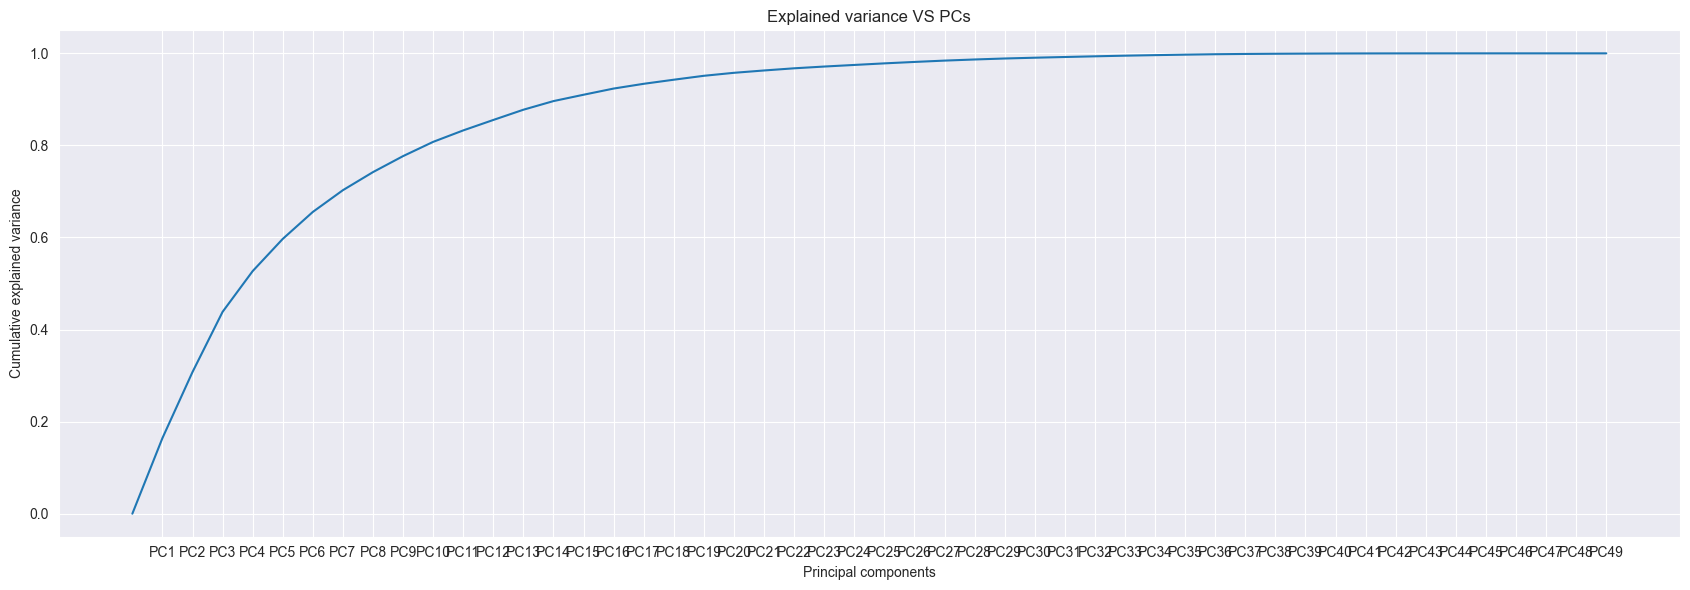

In [217]:
X = working_df_dev.drop(columns=["shares"]).values

pca_1 = PCA(random_state = 42)
pca_1.fit(X)

_, ax = plt.subplots(1,1, figsize = (17,6))
ax.plot(np.insert(np.cumsum(pca_1.explained_variance_ratio_), 0, 0))
ax.set_title('Explained variance VS PCs')
plt.xticks(ticks=np.arange(1, pca_1.n_features_in_ + 1),
           labels=[f'PC{i}' for i in range(1, pca_1.n_features_in_ + 1)])
ax.set_xlabel('Principal components')
ax.set_ylabel('Cumulative explained variance')
ax.grid()
plt.grid()
plt.tight_layout()
plt.show()

In [218]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

pca_25 = PCA(n_components=25, random_state = 42)
pca_25.fit(X)

X_train, X_valid, y_train, y_valid = train_test_split(pca_25.transform(X), y, shuffle=True, random_state=42)

In [219]:
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train, y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8319396924089569
0.12764949202750064


In [220]:
feature_names = working_df_dev.drop(columns=["shares"]).columns
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('timedelta', 0.08057356157787264),
 ('n_tokens_title', 0.05806962727685087),
 ('kw_avg_max', 0.05039316773160914),
 ('self_reference_max_shares', 0.04623651982120672),
 ('self_reference_avg_sharess', 0.043872102289952364),
 ('n_unique_tokens', 0.04214704018006198),
 ('LDA_00', 0.04040729640415479),
 ('n_non_stop_unique_tokens', 0.040222801164992654),
 ('kw_min_max', 0.03886266056524627),
 ('num_imgs', 0.03760869071247786),
 ('self_reference_min_shares', 0.03758515453892725),
 ('kw_max_avg', 0.03712344673649462),
 ('LDA_03', 0.03699289545890539),
 ('num_videos', 0.036940146829092614),
 ('kw_avg_avg', 0.03637153477328553),
 ('LDA_02', 0.036078956030016214),
 ('num_self_hrefs', 0.03601879683607),
 ('LDA_01', 0.03532224015271781),
 ('n_tokens_content', 0.0346266742576881),
 ('kw_min_avg', 0.03369365152921641),
 ('kw_max_min', 0.03367658990534575),
 ('kw_avg_min', 0.033022371046827946),
 ('num_hrefs', 0.03203080599688609),
 ('num_keywords', 0.03132473183681639),
 ('average_token_length', 

In [39]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

pca_16 = PCA(n_components=16, random_state = 42)
pca_16.fit(X)

X_train, X_valid, y_train, y_valid = train_test_split(pca_16.transform(X), y, shuffle=True, random_state=42)
reg = RandomForestRegressor(100, random_state=42)
reg.fit(X_train, y_train)

rms = mean_squared_error(y_valid, reg.predict(X_valid), squared=False)
print(rms)
print(r2_score(y_valid, reg.predict(X_valid)))

0.8606521973872098
0.11506235367672135


## Polynomial regressor

In [221]:
X = working_df_dev.drop(columns=["shares"]).values
y = working_df_dev["shares"].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=42)

In [228]:
pipe = make_pipeline(
    PolynomialFeatures(2),
    Lasso(alpha=0.8)
)
pipe.fit(X_train, y_train)
'''
poli = PolynomialFeatures(2)
poli_train = poli.fit_transform(X_train)
poli_test = poli.fit_transform(X_valid)

reg = LinearRegression()
reg.fit(poli_train, y_train)
preds_poli_reg = reg.predict(poli_test)
'''
preds_poli_reg = pipe.predict(X_valid)

rms = mean_squared_error(y_valid, preds_poli_reg, squared=False)
print(rms)
r2 = r2_score(y_valid, preds_poli_reg)
adj_r2 = 1-(1-r2)*(len(X_valid) - 1)/(len(X_valid) - X_valid.shape[1] - 1)
print(adj_r2)

0.8787049043501293
0.020298736536371598
